# 04 - Mobilitaet pro Bezirk

## Ziel
Ermittelt OePNV- und Radwegeindikatoren pro Stadtbezirk auf OSM-Basis.

## Inputs
- data/interim/muc_bezirke_bev_clean.geojson, OSM-Haltestellen, OSM-Radwege

## Outputs
- data/processed/muc_bezirke_mobility.geojson

## Ausfuehrung
- Von oben nach unten ausfuehren (Restart & Run All).
- Dieses Notebook ist Teil der Pipeline 00 -> 05.


# 04 – Mobility: ÖPNV-Haltestellen je Stadtbezirk (München)

Ziel dieses Notebooks:
- ÖPNV-Haltestellen aus OpenStreetMap für München laden
- Haltestellen den Stadtbezirken räumlich zuordnen
- Kennzahlen pro Bezirk berechnen (z. B. Haltestellen pro 1.000 Einwohner)
- Ergebnis als GeoJSON im Ordner `data/processed/` speichern

Dieses Notebook baut auf dem bereinigten Bezirks-Datensatz aus `01_muc_bezirke_und_bevölkerung.ipynb` auf.


In [1]:
import geopandas as gpd
import osmnx as ox
from pathlib import Path
import matplotlib.pyplot as plt

# Basis-Pfade wie in den anderen Notebooks
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
INTERIM_DIR = DATA_DIR / "interim"
PROCESSED_DIR = DATA_DIR / "processed"

BASE_DIR, INTERIM_DIR, PROCESSED_DIR


(PosixPath('..'), PosixPath('../data/interim'), PosixPath('../data/processed'))

## 1. Basisdaten: Stadtbezirke mit Bevölkerung

Wir laden den bereits bereinigten Datensatz `muc_bezirke_bev_clean.geojson` aus dem Ordner `data/interim/` und verwenden ihn als Geobasis für alle Mobility-Analysen.


In [2]:
gdf_bez = gpd.read_file(INTERIM_DIR / "muc_bezirke_bev_clean.geojson")

# nur relevante Spalten
gdf_bez = gdf_bez[["bez_nr", "name", "einwohner", "geometry"]].copy()

gdf_bez.head()


,bez_nr,name,einwohner,geometry
0,1,Altstadt-Lehel,20876,"POLYGON ((692704.77 5336941.154, 692682.921 53..."
1,2,Ludwigsvorstadt-Isarvorstadt,50081,"POLYGON ((689722.841 5335359.37, 689570.385 53..."
2,3,Maxvorstadt,52434,"POLYGON ((690674.877 5336921.715, 690657.282 5..."
3,4,Schwabing-West,68610,"POLYGON ((691821.837 5339259.125, 691767.291 5..."
4,5,Au-Haidhausen,63972,"POLYGON ((693021.981 5335306.773, 693021.084 5..."


## 2. ÖPNV-Haltestellen aus OpenStreetMap laden

Wir nutzen `osmnx.features_from_place`, um ÖPNV-bezogene Punkte (Bus, Tram, Bahn) für den Raum München aus OSM zu laden.


In [3]:
place_name = "München, Deutschland"

pt_tags = {
    "public_transport": ["platform", "stop_position"],
    "highway": "bus_stop",
    "railway": ["station", "halt", "tram_stop"]
}

gdf_pt_raw = ox.features_from_place(place_name, pt_tags)
len(gdf_pt_raw), gdf_pt_raw.head()


(6408,
                                  geometry  bus                   name network  \
 element id                                                                      
 node    245347  POINT (11.52027 48.14627)  yes    Wilhelm-Hale-Straße     NaN   
         295383  POINT (11.46862 48.17742)  yes      Willi-Wien-Straße     NaN   
         398761  POINT (11.58782 48.13766)  NaN            Maxmonument     MVV   
         428662   POINT (11.71534 48.1364)  yes  Sigmund-Riefler-Bogen     NaN   
         444575  POINT (11.50773 48.15276)  yes      Hirschgartenallee     NaN   
 
                operator public_transport share_taxi  \
 element id                                            
 node    245347      NaN    stop_position        NaN   
         295383      NaN    stop_position        NaN   
         398761      MVG    stop_position        NaN   
         428662      NaN    stop_position        NaN   
         444575      NaN    stop_position        NaN   
 
                       

## 3. Geometrie & CRS: Vorbereitung der ÖPNV-Daten

Die OSM-Geometrien werden in das gleiche Koordinatensystem wie der Bezirkslayer transformiert.  
Falls Flächen/Linien vorkommen, nutzen wir deren Zentroid als Punktrepräsentation.


In [4]:
# in CRS der Bezirke bringen
gdf_pt = gdf_pt_raw.to_crs(gdf_bez.crs).copy()

# sicherstellen, dass wir punktartige Geometrien haben
gdf_pt["geometry"] = gdf_pt.geometry.centroid

# nur Geometrie behalten – Attribute werden für die Kennzahl nicht benötigt
gdf_pt = gdf_pt[["geometry"]].copy()

gdf_pt.head(), gdf_pt.crs


(                                      geometry
 element id                                    
 node    245347  POINT (687462.268 5335630.028)
         295383  POINT (683509.643 5338967.419)
         398761   POINT (692518.78 5334839.865)
         428662  POINT (702009.446 5335026.617)
         444575   POINT (686505.86 5336320.155),
 <Projected CRS: EPSG:25832>
 Name: ETRS89 / UTM zone 32N
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: Europe between 6°E and 12°E: Austria; Denmark - onshore and offshore; Germany - onshore and offshore; Italy - onshore and offshore; Norway including Svalbard - onshore and offshore; Spain - offshore.
 - bounds: (6.0, 36.53, 12.01, 84.01)
 Coordinate Operation:
 - name: UTM zone 32N
 - method: Transverse Mercator
 Datum: European Terrestrial Reference System 1989 ensemble
 - Ellipsoid: GRS 1980
 - Prime Meridian: Greenwich)

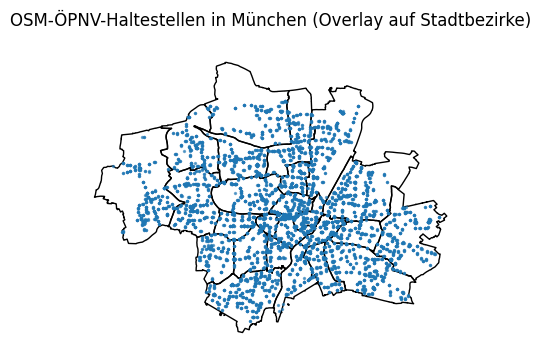

In [5]:
ax = gdf_bez.plot(edgecolor="black", facecolor="none", figsize=(5, 5))
gdf_pt.plot(ax=ax, markersize=2, alpha=0.6)
plt.title("OSM-ÖPNV-Haltestellen in München (Overlay auf Stadtbezirke)")
plt.axis("off")
plt.show()


## 4. Räumlicher Join: Zuordnung der Haltestellen zu Stadtbezirken

Mit einem `sjoin` wird geprüft, welche Haltestelle in welchem Bezirk liegt (`predicate='within'`).  
Damit erhält jede Haltestelle eine Bezirksnummer (`bez_nr`).


In [6]:
pt_in_bez = gpd.sjoin(
    gdf_pt,
    gdf_bez[["bez_nr", "geometry"]],
    how="inner",
    predicate="within"
)

pt_in_bez.head()


geometry  index_right  bez_nr
element id                                                         
node    245347  POINT (687462.268 5335630.028)            8       9
        295383  POINT (683509.643 5338967.419)           22      23
        398761   POINT (692518.78 5334839.865)            0       1
        428662  POINT (702009.446 5335026.617)           14      15
        444575   POINT (686505.86 5336320.155)            8       9

## 5. Aggregation: Kennzahlen pro Stadtbezirk

Aus dem Join leiten wir die Anzahl der Haltestellen pro Bezirk ab und berechnen eine Kennzahl
*Haltestellen pro 1.000 Einwohner*.


In [7]:
# Anzahl Haltestellen je Bezirk
stops_per_bez = (
    pt_in_bez
    .groupby("bez_nr")
    .size()
    .reset_index(name="stops_count")
)

stops_per_bez.head()


,bez_nr,stops_count
0,1,177
1,2,332
2,3,191
3,4,176
4,5,251


In [8]:
# Merge mit Bezirksbasis
gdf_mob = gdf_bez.merge(stops_per_bez, on="bez_nr", how="left")

# Bezirke ohne Haltestelle → 0
gdf_mob["stops_count"] = gdf_mob["stops_count"].fillna(0).astype(int)

# Kennzahl: Haltestellen pro 1.000 Einwohner
gdf_mob["stops_pro_1000_einw"] = (
    gdf_mob["stops_count"] / gdf_mob["einwohner"] * 1000
)

gdf_mob[["bez_nr", "name", "stops_count", "stops_pro_1000_einw"]].head()


,bez_nr,name,stops_count,stops_pro_1000_einw
0,1,Altstadt-Lehel,177,8.478636
1,2,Ludwigsvorstadt-Isarvorstadt,332,6.629261
2,3,Maxvorstadt,191,3.642675
3,4,Schwabing-West,176,2.565224
4,5,Au-Haidhausen,251,3.923592


## 6. Erste EDA: Verteilung & räumliches Muster

Zur Einordnung der Kennzahlen betrachten wir:
- ein Histogramm der Haltestellen pro 1.000 Einwohner
- eine Choroplethenkarte auf Bezirksebene.


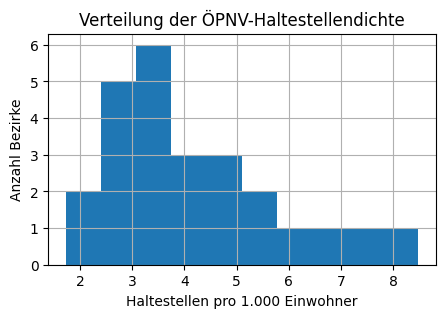

In [9]:
plt.figure(figsize=(5, 3))
gdf_mob["stops_pro_1000_einw"].hist(bins=10)
plt.xlabel("Haltestellen pro 1.000 Einwohner")
plt.ylabel("Anzahl Bezirke")
plt.title("Verteilung der ÖPNV-Haltestellendichte")
plt.show()


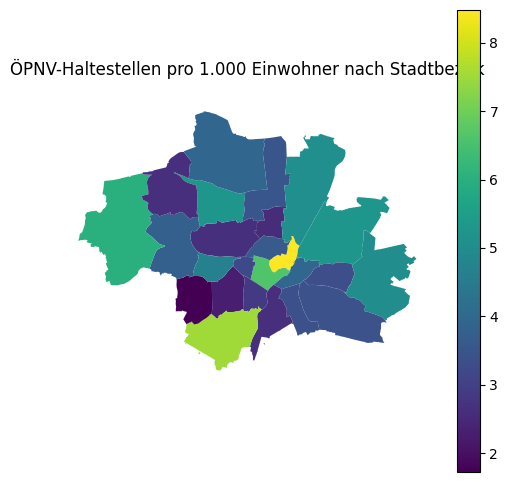

In [10]:
ax = gdf_mob.plot(
    column="stops_pro_1000_einw",
    legend=True,
    figsize=(6, 6)
)
plt.title("ÖPNV-Haltestellen pro 1.000 Einwohner nach Stadtbezirk")
plt.axis("off")
plt.show()


## 7. Export: Mobility-GeoDataFrame speichern

Der aufbereitete Mobility-Datensatz wird als `muc_bezirke_mobility.geojson`
im Ordner `data/processed/` gespeichert und dient später als Input
für das Active-City-Index-Notebook.


In [11]:
out_path = PROCESSED_DIR / "muc_bezirke_mobility.geojson"
gdf_mob.to_file(out_path, driver="GeoJSON")
out_path


PosixPath('../data/processed/muc_bezirke_mobility.geojson')

## 8. Radwege: Länge der Radinfrastruktur je Stadtbezirk

Zusätzlich zur ÖPNV-Erreichbarkeit wird die Länge der Radwege aus OSM erfasst.
Die Radweglänge wird pro Stadtbezirk aggregiert und auf km² normiert 
(*Radweg-Kilometer pro Quadratkilometer*).

In [12]:
# Radwege aus OSM für München laden
cycle_tags = {
    "highway": ["cycleway", "path"],
    "cycleway": True  # erfasst Straßen mit cycleway=* Attribut
}

gdf_cycle_raw = ox.features_from_place(place_name, cycle_tags)
gdf_cycle = gdf_cycle_raw.to_crs(gdf_bez.crs).copy()

# Nur Linien-Geometrien behalten
gdf_cycle = gdf_cycle[gdf_cycle.geometry.type.isin(["LineString", "MultiLineString"])].copy()
gdf_cycle.head()

geometry crossing  \
element id                                                                    
way     2398598  LINESTRING (678321.324 5338985.322, 678330.8 5...      NaN   
        2398599  LINESTRING (678590.705 5338923.23, 678586.813 ...      NaN   
        3186527  LINESTRING (699607.328 5332097.029, 699605.243...      NaN   
        3221457  LINESTRING (689928.521 5338623.048, 689928.253...      NaN   
        3302608  LINESTRING (688726.171 5337858.573, 688726.301...      NaN   

                crossing:island crossing_ref    highway tactile_paving  \
element id                                                               
way     2398598             NaN          NaN  secondary            NaN   
        2398599             NaN          NaN  secondary            NaN   
        3186527             NaN          NaN       path            NaN   
        3221457             NaN          NaN       path            NaN   
        3302608             NaN          NaN       path            NaN   

                    bicycle crossing:markings kerb button_operated  ... image  \
element id                                                          ...         
way     2398598         NaN               NaN  NaN             NaN  ...   NaN   
        2398599         NaN               NaN  NaN             NaN  ...   NaN   
        3186527         yes               NaN  NaN             NaN  ...   NaN   
        3221457  designated               NaN  NaN             NaN  ...   NaN   
        3302608  designated               NaN  NaN             NaN  ...   NaN   

                parking:both:staggered type name:bar name:el name:he name:ru  \
element id                                                                     
way     2398598                    NaN  NaN      NaN     NaN     NaN     NaN   
        2398599                    NaN  NaN      NaN     NaN     NaN     NaN   
        3186527                    NaN  NaN      NaN     NaN     NaN     NaN   
        3221457                    NaN  NaN      NaN     NaN     NaN     NaN   
        3302608                    NaN  NaN      NaN     NaN     NaN     NaN   

                name:sr place tourism  
element id                             
way     2398598     NaN   NaN     NaN  
        2398599     NaN   NaN     NaN  
        3186527     NaN   NaN     NaN  
        3221457     NaN   NaN     NaN  
        3302608     NaN   NaN     NaN  

[5 rows x 318 columns]

In [13]:
# Schnittmenge: Radwege ∩ Bezirke
cycle_in_bez = gpd.overlay(
    gdf_cycle[["geometry"]],
    gdf_bez[["bez_nr", "geometry"]],
    how="intersection"
)

# Länge je Radweg-Segment (in Meter)
cycle_in_bez["length_m"] = cycle_in_bez.geometry.length

cycle_in_bez.head()

,bez_nr,geometry,length_m
0,22,"LINESTRING (678321.324 5338985.322, 678330.8 5...",289.761912
1,22,"LINESTRING (678590.705 5338923.23, 678586.813 ...",321.180731
2,15,"LINESTRING (699607.328 5332097.029, 699605.243...",547.514533
3,11,"LINESTRING (689928.521 5338623.048, 689928.253...",89.115518
4,9,"LINESTRING (688726.171 5337858.573, 688726.301...",302.164243


In [14]:
# Gesamtlänge der Radwege pro Bezirk
cycle_per_bez = (
    cycle_in_bez
    .groupby("bez_nr")["length_m"]
    .sum()
    .reset_index()
    .rename(columns={"length_m": "radweg_length_m"})
)

cycle_per_bez.head()

,bez_nr,radweg_length_m
0,1,25011.805797
1,2,33868.056639
2,3,27996.472342
3,4,37562.549898
4,5,30467.493203


In [15]:
# Radwege an gdf_mob joinen
gdf_mob = gdf_mob.merge(cycle_per_bez, on="bez_nr", how="left")

# NaN (keine Radwege) → 0
gdf_mob["radweg_length_m"] = gdf_mob["radweg_length_m"].fillna(0)

# in km umrechnen
gdf_mob["radweg_km"] = gdf_mob["radweg_length_m"] / 1000

# Radwegdichte: km Radweg pro km² Bezirksfläche
# flaeche_ha ist im Basis-DF, aber in 04 haben wir nur einwohner + geometry geladen.
# Lösung: flaeche_ha aus muc_bezirke_bev_clean nachziehen:
gdf_area = gpd.read_file(INTERIM_DIR / "muc_bezirke_bev_clean.geojson")[["bez_nr", "flaeche_ha"]]
gdf_mob = gdf_mob.merge(gdf_area, on="bez_nr", how="left")

gdf_mob["radweg_km_pro_km2"] = gdf_mob["radweg_km"] / (gdf_mob["flaeche_ha"] / 100)

gdf_mob[["bez_nr", "name", "radweg_km", "radweg_km_pro_km2"]].head()

,bez_nr,name,radweg_km,radweg_km_pro_km2
0,1,Altstadt-Lehel,25.011806,0.079506
1,2,Ludwigsvorstadt-Isarvorstadt,33.868057,0.076943
2,3,Maxvorstadt,27.996472,0.065135
3,4,Schwabing-West,37.562550,0.086087
4,5,Au-Haidhausen,30.467493,0.072198


In [16]:
out_path = PROCESSED_DIR / "muc_bezirke_mobility.geojson"
gdf_mob.to_file(out_path, driver="GeoJSON")
out_path

PosixPath('../data/processed/muc_bezirke_mobility.geojson')